# Constraining FATES parameters for a CA montane shrub

This notebook uses observational data from a list of California montane shrub species to constrain fates parameters for a montane shrub pft in FATES.

## Setup <a class="anchor" id="setup"></a>
* Import libraries
* Set paths to data
* Define constants

In [139]:
#import libraries
import pandas as pd
import numpy as np
from numpy import genfromtxt
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime
import os
#jupyter settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 200)

import re

In [192]:
path_to_trait_obs = "/home/adam/cloud/gdrive/postdoc/parameters/param_data/trait_observations"
write_to_csv = True

In [141]:
def convert_to_fates_units(trait_name,input_units,input_value):

    
    if ("SLA" in trait_name) | ("Specific leaf area" in trait_name) and input_units == "mm2 mg-1":  
        output_value = input_value * m2_per_mm2 * mg_per_g * g_biomass_per_g_C
        return output_value

    elif "Leaf nitrogen" in trait_name and input_units == "mg/g":
        output_value = input_value * g_per_mg * g_biomass_per_g_C
        return output_value

    elif "Stem specific density" in trait_name and input_units == "g/cm3":
        output_value = input_value
        return output_value
    
    # Anaker conversions
    elif trait_name == "log(SLA cm2 g-1)":
        output_value = np.exp(input_value) * m2_per_cm2 * g_biomass_per_g_C
        return output_value
        
    elif trait_name == 'log(wood density g ml-1)':
        output_value = np.exp(input_value)
        return output_value
        
    elif trait_name == 'log(N %)':
        output_value = np.exp(input_value) * 1e-2 * g_biomass_per_g_C
        return output_value
    
    #Jepson leaf N
    elif trait_name == "Leaf Nmass":
    
        # muliplying by 1e-2 is to reverse the "per cent"  
        output_value = input_value * 1e-2 * g_biomass_per_g_C
        return output_value
    
    elif "Wood density" in trait_name:
        output_value = input_value
        return output_value
    
    elif trait_name == "Leaf area to sapwood area" and input_units == "mm2 mm-2":
        output_value = input_value * 1e-4
        return output_value
    
    else:
        #print("No unit conversion known for:", trait_name)
        return None
    
def convert_to_fates_param_name(input_trait_name):
    if ("SLA" in input_trait_name) | ('Specific leaf area' in input_trait_name):
        return "fates_leaf_slatop"
    
    elif ("wood density" in input_trait_name) |  ("Wood density" in input_trait_name):
        return "fates_wood_density"
    
    elif ("N %" in input_trait_name) | ("Leaf Nmass" in input_trait_name):
        return "fates_stoich_nitr"
    
    elif "Leaf area to sapwood area" in input_trait_name:
        return "fates_allom_la_per_sa_int"
    
    else:
        return None
    
def get_sources(df,variable):
    return df.loc[df.fates_name == variable].source.unique()

In [142]:
# List of montane and foothill shrubs in the Sierra Nevada
shrub_sp = os.path.join(path_to_trait_obs,"shrub/montane_and_foothill_shrubs.csv")

# TRY trait data for montane shrubs
try_data = os.path.join(path_to_trait_obs,"shrub/TRY/data_download_8_15_2022/22264.txt")

# Shrub trait data from Anaker et al., 2012
anaker_2012 = os.path.join(path_to_trait_obs,"shrub/Anaker_et_al_2012/Anaker_2012_data.csv")

# Shrub trait data from Jepson database
jepson = os.path.join(path_to_trait_obs,"shrub/Jepson/jepson_data_downloaded_Aug_2022.txt")

# Shrub allometry data from Conti's shrub allometry database
conti_allometry = os.path.join(path_to_trait_obs,"shrub/Conti_et_al_2019_SHRUB_ALLOMETRY_DATABASE/conti_shrub_allom.csv")

# Vcmax data from Misson et al., 2006
misson_vcmax =  os.path.join(path_to_trait_obs,"shrub/Misson_et_al_2006/vcmax_Misson_data.csv")

# Data on Huber value from Preston and Ackerley
preston_ackerley =  os.path.join(path_to_trait_obs,"shrub/Preston&Ackerley_2003/ackerley_preston_data.csv")

In [144]:
#define constants
m2_per_cm2 = 1e-4
g_biomass_per_g_C = 2
m2_per_mm2 = 1e-6
mg_per_g = 1e3
g_per_kg = 1000
mm2_per_cm2 = 100

## Data from Anacker *et al.* (2012) 

**Source**:[Anacker et al. (2012) Dryad data](https://datadryad.org/stash/dataset/doi:10.5061/dryad.jq0t8rc4)

**Traits analyzed**: SLA, woody density, leaf N

Note: each observation is actually a mean of multiple individuals, but I don't have access to the n per observation.

In [145]:
#Import data
anaker_raw = pd.read_csv(anaker_2012)
anaker_vars = list(anaker_raw.columns[1:])

#view the variables available from the Anaker data
print(anaker_vars)

#convert df to long format
anaker_df = anaker_raw.melt(id_vars=['latin'],value_vars=anaker_vars,var_name='orig_var_name', value_name='orig_value')

#add orig units column
anaker_df['orig_units'] = None

#add orig n column
anaker_df['orig_n'] = 1

anaker_df.orig_var_name.value_counts()

['log(SLA cm2 g-1)', 'leaf water content (%)', 'log(wood density g ml-1)', 'log(ht cm)', 'log(N %)']


orig_var_name
log(SLA cm2 g-1)            107
leaf water content (%)      107
log(wood density g ml-1)    107
log(ht cm)                  107
log(N %)                    107
Name: count, dtype: int64

### Convert to FATES units

In [146]:
#convert units to fates units
fates_values = anaker_df.apply(lambda x: convert_to_fates_units(x['orig_var_name'], None, x["orig_value"]), axis=1)
anaker_df['fates_value'] = fates_values

#convert variable names to fates names
fates_names = anaker_df.apply(lambda x: convert_to_fates_param_name(x["orig_var_name"]),axis = 1)
anaker_df["fates_name"] = fates_names

#add the data source 
anaker_df['source'] = 'Anacker_et_al_2012'

print(anaker_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   latin          535 non-null    object 
 1   orig_var_name  535 non-null    object 
 2   orig_value     464 non-null    float64
 3   orig_units     0 non-null      object 
 4   orig_n         535 non-null    int64  
 5   fates_value    266 non-null    float64
 6   fates_name     321 non-null    object 
 7   source         535 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.6+ KB
None


## Jepson Ecological Flora Pilot

[Jepson Ecological Flora Pilot](https://ucjeps.berkeley.edu/EFT.html)

[Jepson query URL](https://ucjeps.berkeley.edu/cgi-bin/DT.pl?wanted_genus=Adenostoma&wanted_genus=Arctostaphylos&wanted_genus=Ceanothus&wanted_genus=Cercocarpus&wanted_genus=Chamaebatia&wanted_genus=Heteromeles&wanted_genus=Prunus&wanted_genus=Quercus&wanted_genus=Rhamnus)

**Traits analyzed**: SLA, woody density, leaf N

The max and min elevation data fields in Jepson could also be useful at some point.

Many of these observations are means of multiple observations (i.e. n for many observations > 1). See Jepson query link above for n values. However, the standard deviation of these means doesn't seem to be available.

### Import, clean, and view the raw Jepson data

In [147]:
#import jepson data
jepson_raw = pd.read_csv(jepson, sep='\t', header=None)
jepson_raw.columns = ['latin','orig_var_name','orig_value','orig_units','orig_n']

#All Jepson trait data available.
print("\n")
print("All Jepson traits:")
print(jepson_raw.orig_var_name.value_counts())

#Filter to traits of interest
jepson_raw = jepson_raw[jepson_raw.orig_var_name.isin(['Specific leaf area','Wood density','Leaf Nmass','Leaf area to sapwood area'])]

#convert n to integer
def get_int(string_with_int):
    return int(re.findall(r'\d+', string_with_int)[0])

n_int = jepson_raw.apply(lambda x: get_int(x['orig_n']),axis = 1)
jepson_raw['orig_n'] = n_int

#convert value to flot
jepson_raw['orig_value'] = jepson_raw['orig_value'].astype('float64')



All Jepson traits:
orig_var_name
Low elevation                           234
High elevation                          234
Blade area (c)                           89
Specific leaf area                       89
Seed mass                                85
Leaf type                                84
Blade length (c)                         60
Blade width (c)                          60
Leaf thickness                           26
Wood density                             13
Leaf Nmass                               13
Maximum height (c)                       13
Leaf area to sapwood area                13
Leaf Narea                               13
Annual seed production per plant (c)      8
Name: count, dtype: int64


### Convert Jepson trait units to fates parameter units

In [148]:
#convert units to fates units
jepson_df = jepson_raw

fates_values = jepson_df.apply(lambda x: convert_to_fates_units(x['orig_var_name'], x['orig_units'], x["orig_value"]), axis=1)
jepson_df['fates_value'] = fates_values
fates_names = jepson_df.apply(lambda x: convert_to_fates_param_name(x["orig_var_name"]),axis = 1)
jepson_df['fates_name'] = fates_names

jepson_df['source'] = 'jepson'

print(jepson_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, 1 to 1025
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   latin          128 non-null    object 
 1   orig_var_name  128 non-null    object 
 2   orig_value     128 non-null    float64
 3   orig_units     128 non-null    object 
 4   orig_n         128 non-null    int64  
 5   fates_value    128 non-null    float64
 6   fates_name     128 non-null    object 
 7   source         128 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 9.0+ KB
None


In [149]:
jepson_df

,latin,orig_var_name,orig_value,orig_units,orig_n,fates_value,fates_name,source
1,Adenostoma fasciculatum,Specific leaf area,4.750,mm2 mg-1,11,0.009500,fates_leaf_slatop,jepson
7,Adenostoma fasciculatum,Wood density,0.751,g cm-3,1,0.751000,fates_wood_density,jepson
8,Adenostoma fasciculatum,Leaf Nmass,1.020,%,1,0.020400,fates_stoich_nitr,jepson
10,Adenostoma fasciculatum,Leaf area to sapwood area,11.300,mm2 mm-2,1,0.001130,fates_allom_la_per_sa_int,jepson
15,Adenostoma sparsifolium,Specific leaf area,6.590,mm2 mg-1,6,0.013180,fates_leaf_slatop,jepson
23,Arctostaphylos andersonii,Specific leaf area,4.870,mm2 mg-1,1,0.009740,fates_leaf_slatop,jepson
33,Arctostaphylos bakeri ssp. bakeri,Specific leaf area,4.230,mm2 mg-1,1,0.008460,fates_leaf_slatop,jepson
86,Arctostaphylos hispidula,Specific leaf area,4.970,mm2 mg-1,1,0.009940,fates_leaf_slatop,jepson
94,Arctostaphylos hookeri ssp. franciscana,Specific leaf area,4.160,mm2 mg-1,2,0.008320,fates_leaf_slatop,jepson
101,Arctostaphylos hookeri ssp. hookeri,Specific leaf area,4.310,mm2 mg-1,1,0.008620,fates_leaf_slatop,jepson


## TRY database


Could also use the rooting depth data here if needed

### Load, filter, and process TRY data

In [150]:
#import Try data
try_df_raw = pd.read_csv(try_data, sep="\t", encoding='latin1')[['ObservationID','SpeciesName','AccSpeciesName','TraitID','TraitName','OrigValueStr','OrigUnitStr','StdValue','UnitName','ErrorRisk']]

#print the traits I got from TRY here.
print(try_df_raw.TraitName.value_counts())

#N units in TRY: g N m-2
#There are no TRY entries that have leaf N and SLA, so can't calculate this variable in FATES units.

fates_relevant_traits = ['Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)',
                         'Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): undefined if petiole is in- or excluded',
                         'Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): petiole excluded',
                         'Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): petiole included']

try_df = try_df_raw.loc[try_df_raw.TraitName.isin(fates_relevant_traits)]


fates_values = try_df.apply(lambda x: convert_to_fates_units(x['TraitName'], x['UnitName'], x["StdValue"]), axis=1)
fates_names = try_df.apply(lambda x: convert_to_fates_param_name(x["TraitName"]),axis = 1)


try_df = try_df[["AccSpeciesName","TraitName","StdValue","UnitName"]].rename({"AccSpeciesName":"latin",
                                                                    "TraitName":"orig_var_name",
                                                                    "StdValue":"orig_value",
                                                                    "UnitName":"orig_units"}, axis="columns")
try_df['orig_n'] = 1
try_df['fates_value'] = fates_values
try_df['fates_name'] = fates_names
try_df['source'] = "try"

print("\n")
print("Processed data:")
print(try_df.info())

TraitName
Xylem hydraulic vulnerability, xylem cavitation vulnerability, embolism vulnerability, (P20, P50, P80)     171
Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): undefined if petiole is in- or excluded    110
Plant height vegetative                                                                                     86
Leaf nitrogen (N) content per leaf area                                                                     79
Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): petiole excluded                            41
Leaf carbon (C) content per leaf area                                                                       35
Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)                           25
Xylem hydraulic vulnerability curve (P20, P50, P80)                                                         24
Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): petiole included                      

## Preston & Ackerley, 2003 

[Preston and Ackerley, 2003](https://bsapubs.onlinelibrary.wiley.com/doi/full/10.3732/ajb.90.10.1502) have 26 values of inverse Huber value for C. int.


Nothing is being done with this data for now.

In [151]:
presAck = pd.read_csv(preston_ackerley)

#fates units: converting to leaf area (m2) per sapwood area (cm2)
presAck['leaf_area_per_stem_cross_sectional_area'] = presAck.total_leaf_area_cm2 / presAck.stem_cross_section_area_mm2 * m2_per_cm2 * mm2_per_cm2 

#would need to convert to leaf area per sapwood area to get good values for the fates param: fates_allom_la_per_sa_int
presAck.head()

,stem_cross_section_area_mm2,total_leaf_area_cm2,leaf_area_per_stem_cross_sectional_area
0,1.534781,12.197640,0.079475
1,2.621831,10.767662,0.041069
2,2.511886,12.795701,0.050941
3,3.855196,14.160042,0.036730
4,5.548634,15.492021,0.027920


## Misson et al., 2006

Obsevations of Vcmax are from Fig. 2 of [Misson et al., 2006](https://academic.oup.com/treephys/article/26/6/729/1647694).

In [152]:
# The following observations are from 
# observations of A. patula and C. cordulatus shown in Fig. 2 of Mission et al., 2006
from numpy import genfromtxt
my_data = genfromtxt(misson_vcmax, delimiter=',')[1:,:] #exclude first row
my_data = my_data[:,1]


# Convert to same format as the data above

misson_df = pd.DataFrame({'fates_value':my_data})
misson_df['latin'] = "Ceanothus cordulatus"
misson_df['fates_name'] = 'fates_leaf_vcmax25top'
misson_df['source'] = "misson"

for n in ['orig_var_name', 'orig_value', 'orig_units', 'orig_n']:
    misson_df[n] = None
    
misson_df = misson_df[try_df.columns]
misson_df

,latin,orig_var_name,orig_value,orig_units,orig_n,fates_value,fates_name,source
0,Ceanothus cordulatus,None,None,None,None,65.660315,fates_leaf_vcmax25top,misson
1,Ceanothus cordulatus,None,None,None,None,76.806917,fates_leaf_vcmax25top,misson
2,Ceanothus cordulatus,None,None,None,None,87.581231,fates_leaf_vcmax25top,misson
3,Ceanothus cordulatus,None,None,None,None,92.299813,fates_leaf_vcmax25top,misson
4,Ceanothus cordulatus,None,None,None,None,86.338804,fates_leaf_vcmax25top,misson
5,Ceanothus cordulatus,None,None,None,None,98.269633,fates_leaf_vcmax25top,misson
6,Ceanothus cordulatus,None,None,None,None,92.337262,fates_leaf_vcmax25top,misson
7,Ceanothus cordulatus,None,None,None,None,43.783456,fates_leaf_vcmax25top,misson
8,Ceanothus cordulatus,None,None,None,None,55.707677,fates_leaf_vcmax25top,misson
9,Ceanothus cordulatus,None,None,None,None,59.474612,fates_leaf_vcmax25top,misson


## Define species groups of interest

In [153]:
# This just includes the species we're primarily trying to model.
# The target species are used for allometry
target_shrubs = ['Arctostaphylos patula','Arctostaphylos manzanita',
                       'Ceanothus cordulatus','Ceanothus cuneatus',
                       'Ceanothus integerrimus','Ceanothus velutinus']

#Get species codes for target shrub
sp_list_code = []
for i in target_shrubs:
    tmp = (i.split(" ")[0][:3] + i.split(" ")[1][:3]).upper()
    sp_list_code.append(tmp)
    
print("SP code:",sp_list_code)


# Load species list of montane shrubs and foothill shrubs
shrubs_sp_df = pd.read_csv(shrub_sp)

# This includes foothill shrubs
all_shrubs = shrubs_sp_df.latin

# This just includes shrubs in the MCF ecosystem
montane_shrubs = shrubs_sp_df.loc[shrubs_sp_df.pft == "montane_shrub"]['latin']

SP code: ['ARCPAT', 'ARCMAN', 'CEACOR', 'CEACUN', 'CEAINT', 'CEAVEL']


## Join and view data from Anacker, Jepson, TRY, and Misson

In [154]:
trait_df = pd.concat([anaker_df,jepson_df,try_df,misson_df],axis=0)
print(trait_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 880 entries, 0 to 17
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   latin          880 non-null    object 
 1   orig_var_name  862 non-null    object 
 2   orig_value     790 non-null    float64
 3   orig_units     326 non-null    object 
 4   orig_n         862 non-null    object 
 5   fates_value    610 non-null    float64
 6   fates_name     666 non-null    object 
 7   source         880 non-null    object 
dtypes: float64(2), object(6)
memory usage: 61.9+ KB
None


## Get summary stats on target shrubs, montane shrubs, all shrubs, and all ARCT / CEAN genus

In [155]:
# Create datasets with different groups of species
trait_df_target_shrubs = trait_df.loc[trait_df.latin.isin(target_shrubs)]
trait_df_montane_shrubs = trait_df.loc[trait_df.latin.isin(montane_shrubs)]
trait_df_all_shrubs = trait_df.loc[trait_df.latin.isin(all_shrubs)]
arct_cean_filter = [("Arctostaphylos" in l) | ("Ceanothus" in l) for l in trait_df.latin]
trait_df_arct_cean = trait_df.loc[arct_cean_filter]

d = [trait_df_target_shrubs,trait_df_montane_shrubs,trait_df_all_shrubs,trait_df_arct_cean]
d_names = ["target-shrubs","montane-shrubs","all_shrubs","arct-cean"]

In [156]:
def get_range_data(df,subset_name):

    summary_stats = df.groupby('fates_name')['fates_value'].agg(
        min_value='min',
        max_value='max',
        mean='mean',
        median='median',
        sample_size='size'
    )

    summary_stats['subset_name'] = subset_name
    
    return summary_stats

trait_ranges = []

# Generate the trait ranges for different groups of species
for i in range(len(d)):
    trait_ranges.append(get_range_data(d[i],d_names[i]))

# Concatenate the trait ranges
trait_range_df = pd.concat(trait_ranges,axis=0).sort_values("fates_name").reset_index()

# Add the sources that contribute to each parameter range
sources = []
for v in trait_range_df['fates_name']:
    sources.append(",".join(get_sources(trait_df,v)))
    
trait_range_df['sources'] = sources
trait_range_df

,fates_name,min_value,max_value,mean,median,sample_size,subset_name,sources
0,fates_allom_la_per_sa_int,0.001130,0.007010,0.004070,0.004070,2,all_shrubs,jepson
1,fates_allom_la_per_sa_int,0.000638,0.001180,0.000909,0.000909,2,arct-cean,jepson
2,fates_leaf_slatop,0.005644,0.053800,0.011585,0.009190,102,arct-cean,"Anacker_et_al_2012,jepson,try"
3,fates_leaf_slatop,0.005651,0.095210,0.026366,0.021853,189,all_shrubs,"Anacker_et_al_2012,jepson,try"
4,fates_leaf_slatop,0.006740,0.053800,0.012300,0.008811,31,target-shrubs,"Anacker_et_al_2012,jepson,try"
5,fates_leaf_slatop,0.006740,0.095210,0.034311,0.029533,129,montane-shrubs,"Anacker_et_al_2012,jepson,try"
6,fates_leaf_vcmax25top,43.783456,136.317876,86.558603,86.960018,18,montane-shrubs,misson
7,fates_leaf_vcmax25top,43.783456,136.317876,86.558603,86.960018,18,all_shrubs,misson
8,fates_leaf_vcmax25top,43.783456,136.317876,86.558603,86.960018,18,target-shrubs,misson
9,fates_leaf_vcmax25top,43.783456,136.317876,86.558603,86.960018,18,arct-cean,misson


In [157]:
#fig, axes = plt.subplots(ncols=3, figsize=(10,4))
# ds.GPP.sel(time='2001').plot(ax=axes[0], color='green')
# ds.ELAI.sel(time='2001').plot(ax=axes[1], color='blue')
#plt.hist(fates_param_obs_montane_shrub[fates_param_obs_montane_shrub.parameter_name == "fates_leaf_slatop"].parameter_value)
#plt.xlabel("m2 per gC")
#get min, max, and mean of each trait

# def getMinMaxMeanFromData(p, df=fates_param_obs_montane_shrub):
#     mean_val = df[df.parameter_name == p].parameter_value.mean()
#     pctile_5 = np.quantile(df[df.parameter_name == p].parameter_value,0.05)
#     pctile_95 = np.quantile(df[df.parameter_name == p].parameter_value,0.95)
#     return np.array([mean_val, pctile_5, pctile_95])

# def update_fates_param_dict(param_string):
#     param = globals()[param_string]
#     my_dict['param_name'].append(param_string)
#     my_dict['mean_val'].append(param[0])
#     my_dict['min_val'].append(param[1])
#     my_dict['max_val'].append(param[2])
#     return(my_dict)

# fates_leaf_slatop = getMinMaxMeanFromData(p="fates_leaf_slatop")
# fates_leaf_slamax = fates_leaf_slatop
# fates_stoich_nitr = getMinMaxMeanFromData(p="fates_stoich_nitr")
# fates_wood_density = getMinMaxMeanFromData(p="fates_wood_density")

# print("fates_stoich_nitr",round(fates_stoich_nitr[0],4), "g N / g C")
# print("fates_leaf_slatop",round(fates_leaf_slatop[0], 4), "m2 / g C")
# print("fates_wood_density",round(fates_wood_density[0], 4), "g cm3")


# my_dict = update_fates_param_dict('fates_stoich_nitr')
# my_dict = update_fates_param_dict('fates_leaf_slatop')
# my_dict = update_fates_param_dict('fates_leaf_slamax')
# my_dict = update_fates_param_dict('fates_wood_density')

## Shrub allometry

This section focuses on constraining fates allometry parameters from observations.

In [158]:
#diamter to height
def d2h_obrien(d,p1,p2,dbh_maxh):
    h = []
    for i in d:
        h.append(10.0**(math.log10(min(i,dbh_maxh))*p1+p2))
    return(h)

# #diameter to max leaf biomass
# def d2blmax_salda(d,p1,p2,p3,wood_density,dbh_maxh):
#     if d < dbh_maxh:
#         blmax = p1 * d**p2 * wood_density**p3
#     else:
#         blmax = p1 * dbh_maxh**p2 * wood_density**p3
#     return(blmax)

# #diameter and height to above-ground biomass (just structural and sapwood biomass)
# def dh2bagw_salda(p1, p2, p3, p4, allom_agb_frac,d,h,wood_density):
#     bagw = allom_agb_frac*p1*(h**p2)*(d**p3)*(wood_density**p4)
#     return(bagw)

#2-param power function for diameter (cm) to plant above-ground biomass (kgC)
def d2bagw_2pwr(d,p1,p2,c2b):
    bagw = []
    for i in d:
        bagw.append((p1 * i**p2)/c2b)
    return bagw

#This is a power function for leaf biomass from plant diameter
def d2blmax_2pwr(d,p1,p2,c2b,dbh_maxh):
    blmax = []
    for i in d:
        blmax.append((p1*min(i,dbh_maxh)**p2) / c2b)   
    return blmax

def carea_2pwr(d, p1, p2):
    c = []
    for i in d:
        c.append(p1 * i ** p2)
    return c

def d_to_crown_diameter_fates(dbh,d2bl_p2,d2bl_ediff,spread,d2ca_max,d2ca_min):

    #from fates
    crown_area_to_dbh_exponent = d2bl_p2 + d2bl_ediff
    spreadterm = spread * d2ca_max + (1.0 - spread) * d2ca_min
    c_area = spreadterm * dbh ** crown_area_to_dbh_exponent

    #convert to crown diameter
    #crown_diameter = 2 * math.sqrt(c_area/math.pi)

    return c_area

### Define other functions

In [159]:
def age_senescence(age, mort_r_age_senescence, mort_ip_age_senescence):
    out = []
    for i in age:
        out.append(1.0 / (1.0 + math.exp(-1 * mort_r_age_senescence * (i - mort_ip_age_senescence))))
    return out


def size_senescence(size, mort_r_size_senescence, mort_ip_size_senescence):
    out = []
    for i in size:
        out.append(1.0 / (1.0 + math.exp(-1 * mort_r_size_senescence * (i - mort_ip_size_senescence))))
    return out

### Define supporting allometric functions

There is no single source where measurements are available on all the necessary biomass components to fit fates's allometric models. By using these "supporting" allometric functions, based on observations, we estimate the values of missing measurements for individuals in the [shrub allometry database](https://doi.org/10.5061/dryad.282bm46) (Conti *et al*., 2019). Conti's shrub allometry database is the most complete source of allometric measurements on shrubs availble to us. With the extra measurements calculated here we can parameterize Fates's allometric models.

#### Basal diameter to total above-ground biomass

The allometric model and parameters below are from Table 1 of [Lutz et al., 2017](https://fireecology.springeropen.com/articles/10.4996/fireecology.1301104) which is based on Means et al., 1994.

Parameters are for:
 * *Arctostaphylos patula*
 * *C. velutinus* 
 * *C. integerrimus*
 
These two Ceanothus species are very common in the post-fire areas of the Sierra Nevada.

##### Define allometric model used in Lutz et al., 2017
This model predicts total above-ground biomass per individual as a function of basal diameter.

In [160]:
#allometric model from Lutz et al. (2017) to predict shrub above-ground biomass as a function of basal diameter
def lutz_agb(dba,A,B):
    return math.exp(A + math.log(dba**B))

#inverse of the above
#function to predict basal diameter (cm) as a function of total AGB (g)
def bd_from_AGB(agb,A,B):
    return math.exp((math.log(agb) - A) / B)

#define parameters
Lutz_AGB_params = pd.DataFrame({"sp":["ARCPAT","CEOVEL","CEOINT"],
                                "A": [3.3186,3.6167,3.6672],
                                "B": [2.6846,2.2043,2.65018]})

##### Visualize basal diameter to total AGB

This code chunk also defines this relationship 

/tmp/ipykernel_5826/3847657182.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.exp(A + math.log(dba**B))


MONTANE SHRUB A: 3.5341666666666662
MONTANE SHRUB B: 2.5130266666666667


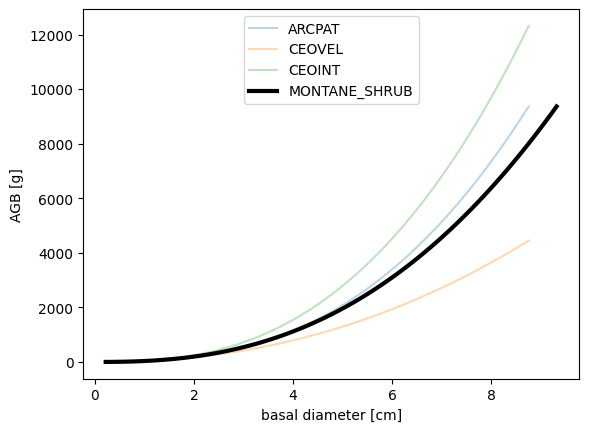

In [161]:
#give range of shrub basal diameters
#range based on range of observed basal diameters for CA montane shrubs in Huff et al., 2017
dba_shrubs = np.arange(0.26,8.8,0.1)

#predict AGB for C. int, C. vel., and ARCPAT for the basal diameters above. 
agb = np.zeros((len(dba_shrubs),3))
for c, p in enumerate(Lutz_AGB_params.sp):

    condition = Lutz_AGB_params.sp == p
    for k, i in enumerate(dba_shrubs):
        tmp = lutz_agb(i, A=Lutz_AGB_params.A[condition],
                       B=Lutz_AGB_params.B[condition])
        agb[k,c] = tmp
        
        
#plot species-level allometry
plt.plot(dba_shrubs,agb[:,0], label = "ARCPAT", alpha = 0.3)
plt.plot(dba_shrubs,agb[:,1], label = "CEOVEL", alpha = 0.3)
plt.plot(dba_shrubs,agb[:,2], label = "CEOINT", alpha = 0.3)

#add the mean line (i.e. the montane_shrub model)
#agb_synth = [1,10,100,500,1000,3000,5000,7000,10000]
bd_montane_shrub = [] 

for i,agb_i in enumerate(agb[:,0]):
    tmp = bd_from_AGB(A=Lutz_AGB_params.A.mean(), B=Lutz_AGB_params.B.mean(), agb = agb_i)
    bd_montane_shrub.append(tmp)

plt.plot(bd_montane_shrub, agb[:,0], linewidth = 3, color = "black", label = "MONTANE_SHRUB")  
plt.xlabel('basal diameter [cm]')
plt.ylabel('AGB [g]')
plt.legend(loc='upper center')

#mean param value for bd to agb for montane shrub
print("MONTANE SHRUB A:",Lutz_AGB_params.A.mean())
print("MONTANE SHRUB B:",Lutz_AGB_params.B.mean())

#### Crown area to leaf biomass

We used allometric models shown in Table 4 of [Huff et al., 2017](https://www.sciencedirect.com/science/article/pii/S0378112716311525) to estimate leaf biomass from crown area for individuals in the shrub allometry database (Conti et al., 2019).

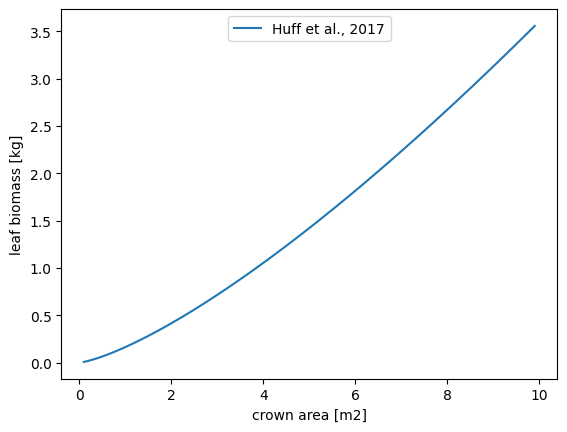

In [162]:
#define allometric model to calculate leaf biomass (kg) from crown area m2
def ca2bl(a,b,ca):
    bls = []
    for i in range(len(ca)):
        bls.append(a*ca[i]**b)
    return bls

#The parameters used are the average of those in Table 4 of Huff et al., 2017 for the following species: greenleaf manzanita (ARCPAT),
#mountain whitethorn (CEOCOR), deerbrush (CEOINT), and snowbrush (CEOVEL), 
ca2bl_a = np.array([0.2910,0.1080,0.0452,0.2106]).mean()
ca2bl_b = np.array([0.9703, 1.366, 1.841, 1.1937]).mean()

#provide range of crown areas (m2)
cas = np.arange(0.1,10,0.1)

#calculate leaf biomass (kg) from crown area
bleafs = ca2bl(a = ca2bl_a, b =ca2bl_b, ca= cas)

#plot the relationship between crown area and leaf biomass
plt.plot(cas,bleafs,label = "Huff et al., 2017")
plt.xlabel('crown area [m2]')
plt.ylabel('leaf biomass [kg]')
plt.legend(loc='upper center')

### Shrub allometry database
[Conti et al., 2019](https://onlinelibrary.wiley.com/doi/10.1111/geb.12907)


[Dryad data for Conti et al., 2019](https://doi.org/10.5061/dryad.282bm46)

#### Import, clean, and add measurement estimates

Added measurement estimates for:
* basal diameter
* leaf biomass
* above-ground woody biomass

In [163]:
#Import and filter Conti data
conti_raw = pd.read_csv(conti_allometry)

#Filter to get species of interest 
print('species in Conti et al., 2017:')
print(conti_raw[conti_raw.spp.isin(sp_list_code)].spp.unique())
conti_raw = conti_raw[conti_raw.spp.isin(sp_list_code)]

#convert AGB to grams
conti_raw['AGB_g'] = conti_raw.AGB * g_per_kg

#add basal diameter to the Conti data
bd_lutz = [] 
for i in range(conti_raw.shape[0]):
    tmp = bd_from_AGB(A=Lutz_AGB_params.A.mean(), B=Lutz_AGB_params.B.mean(), agb = list(conti_raw.AGB_g)[i])
    bd_lutz.append(tmp)
conti_raw['BD_Lutz'] = bd_lutz

#add crown area (m2), based on crown diameter
#assuming that the shrub crowns are circular
conti_raw['crown_area'] = math.pi * (conti_raw.CD / 2)**2

#add leaf biomass from crown area
conti_raw['leaf_biomass'] = ca2bl(a=ca2bl_a,b=ca2bl_b,ca=list(conti_raw.crown_area))
conti_raw['leaf_biomass_kg_C'] = conti_raw.leaf_biomass / g_biomass_per_g_C

#add above-ground woody biomass from AGB and leaf biomass
agb_woody = conti_raw.AGB - conti_raw.leaf_biomass
agb_woody[agb_woody < 0] = None
conti_raw['AGB_woody'] = agb_woody
conti_raw['AGB_woody_kg_C'] = agb_woody / g_biomass_per_g_C

species in Conti et al., 2017:
['ARCPAT' 'CEAVEL' 'CEAINT' 'CEACOR']


#### Set up dictionary to hold the FATES allometry parameters

This dictionary has the same columns as `trait_range_df` so they can be joined

In [164]:
allometry_dict = {}

for i in trait_range_df.columns[:4]:
    allometry_dict[i] = []

    
def add_param_to_allometry_dict(fates_name,min_max_mean):
    
    allometry_dict["fates_name"].append(fates_name)
    allometry_dict["min_value"].append(min_max_mean[0])
    allometry_dict["max_value"].append(min_max_mean[1])
    allometry_dict["mean"].append(min_max_mean[2])
    
    
# This function gets the optimal parameter value from the curve fit function and
# also returns the min and max values for the parameter (+- 1 SD of error)
def getMeanMinMaxofParam(param):
    sd_of_param = np.sqrt(np.diag(pcov))[param]
    mean_value = popt[param]
    min_value = popt[param] - sd_of_param
    max_value = popt[param] + sd_of_param
    return(np.array([min_value, max_value, mean_value]))

#### Max Size
fates_allom_dbh_maxheight (cm)

(array([20., 27., 16., 17.,  2.,  1.,  0.,  1.,  1.,  1.]),
 array([ 0.612578  ,  2.22275588,  3.83293376,  5.44311164,  7.05328951,
         8.66346739, 10.27364527, 11.88382315, 13.49400103, 15.1041789 ,
        16.71435678]),
 <BarContainer object of 10 artists>)

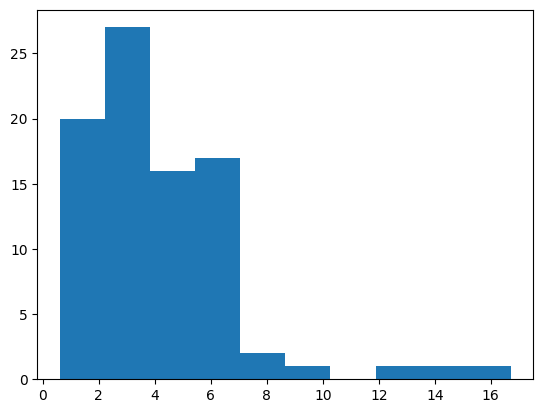

In [165]:
#histogram of basal diameter
plt.hist(conti_raw['BD_Lutz'])

In [166]:
#This parameter range is based off the 95th percentil and max shrub size in the Conti data
dbh_min_value = np.quantile(conti_raw['BD_Lutz'],0.95)
dbh_max_value = max(conti_raw['BD_Lutz'])
dbh_mean_value = np.mean([dbh_min_value,dbh_max_value])

add_param_to_allometry_dict("fates_allom_dbh_maxheight",np.array([dbh_min_value,dbh_max_value,dbh_mean_value]))

#### Basal diameter (cm) to height (m)
Using the O'Brien model to find:

 * d2h1
 * d2h2

The default parameters in fates for d2h1 and d2h2 do not fit observations in the Conti dataset. Nor do the parameters from Ma et al., 2021 Supplement. Ma must be using a different allometric model.

##### Fit the O'brien model for d2h to the Conti data

In [167]:
conti_BD_H = conti_raw[["BD_Lutz","H"]]
conti_BD_H = conti_BD_H[conti_BD_H['H'].notna()]

dbh_maxh = allometry_dict['mean'][0]

# Fit the allometry model
popt, pcov = curve_fit(lambda d, p1, p2: d2h_obrien(d, p1, p2, dbh_maxh), xdata=list(conti_BD_H.BD_Lutz), ydata=list(conti_BD_H.H))


#get mean, min, and max param values for the parameter
#get a range in the parameter estimates
#minus 1 "SD error" (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) of the parameter estimates
fates_allom_d2h1_min_max_mean = getMeanMinMaxofParam(param = 0)
fates_allom_d2h2_min_max_mean = getMeanMinMaxofParam(param = 1)


# Add to the allometry dict
add_param_to_allometry_dict("fates_allom_d2h1",fates_allom_d2h1_min_max_mean)

add_param_to_allometry_dict("fates_allom_d2h2",fates_allom_d2h2_min_max_mean)

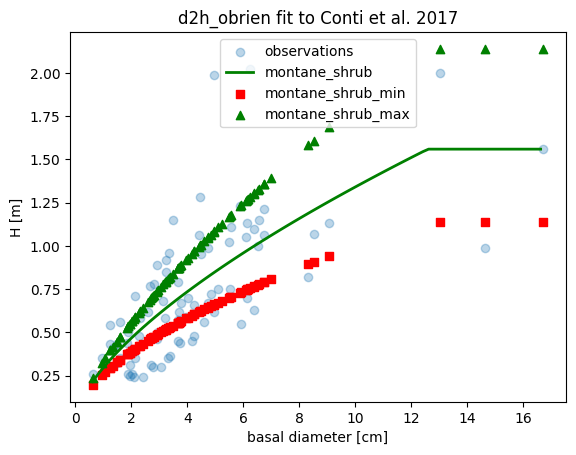

In [168]:
plt.scatter(conti_raw.BD_Lutz, conti_raw.H, label = "observations", alpha = 0.3)

basal_diams = np.arange(conti_raw.BD_Lutz.min(),conti_raw.BD_Lutz.max(),0.2)

H_model = d2h_obrien(basal_diams, p1 = fates_allom_d2h1_min_max_mean[2], p2 = fates_allom_d2h2_min_max_mean[2], dbh_maxh= dbh_maxh)
H_model_min = d2h_obrien(conti_raw.BD_Lutz, p1 = fates_allom_d2h1_min_max_mean[0], p2 = fates_allom_d2h2_min_max_mean[0], dbh_maxh= dbh_maxh)
H_model_max = d2h_obrien(conti_raw.BD_Lutz, p1 = fates_allom_d2h1_min_max_mean[1], p2 = fates_allom_d2h2_min_max_mean[1], dbh_maxh= dbh_maxh)

plt.plot(basal_diams, H_model, label = "montane_shrub",color = "green", lw = 2)
plt.scatter(conti_raw.BD_Lutz, H_model_min, label = "montane_shrub_min",color = "red", marker = "s")
plt.scatter(conti_raw.BD_Lutz, H_model_max, label = "montane_shrub_max",color = "green", marker = "^")
plt.xlabel('basal diameter [cm]')
plt.ylabel('H [m]')
plt.legend(loc='upper center')
plt.title("d2h_obrien fit to Conti et al. 2017")
plt.show()

#### Basal diameter (cm) to leaf biomass (d2blmax_2pwr)

 * fates_allom_d2bl1
 * fates_allom_d2bl2

fates_allom_d2bl1 = 0.019195792110088823 ; fates_allom_d2bl2 = 1.8565094640488953


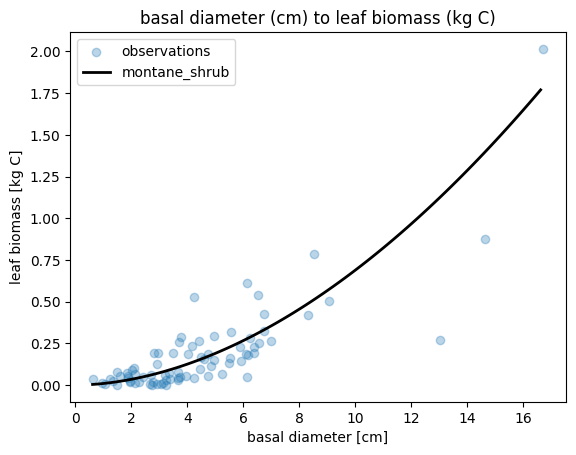

In [169]:
#visualize relationship between basal diameter and leaf biomass
plt.scatter(conti_raw.BD_Lutz,conti_raw.leaf_biomass_kg_C, alpha = 0.3,
            label = "observations")
plt.xlabel('basal diameter [cm]')
plt.ylabel('leaf biomass [kg C]')


conti_BD_LB = conti_raw[["BD_Lutz","leaf_biomass_kg_C"]]
conti_BD_LB = conti_BD_LB[conti_BD_LB['leaf_biomass_kg_C'].notna()]


#find optimal parameters for d2blmax_2pwr
c2b = g_biomass_per_g_C
popt, pcov = curve_fit(lambda d, p1, p2: d2blmax_2pwr(d, p1, p2, c2b, dbh_maxh),
                       xdata=list(conti_BD_LB.BD_Lutz), ydata=list(conti_BD_LB.leaf_biomass_kg_C))


fates_allom_d2bl1 = getMeanMinMaxofParam(param = 0)
fates_allom_d2bl2 = getMeanMinMaxofParam(param = 1)

print("fates_allom_d2bl1 =",fates_allom_d2bl1[2], ";" , "fates_allom_d2bl2 =" , fates_allom_d2bl2[2])


# Add to the allometry dict
add_param_to_allometry_dict("fates_allom_d2bl1",fates_allom_d2bl1)
add_param_to_allometry_dict("fates_allom_d2bl2",fates_allom_d2bl2)

#add the montane shrub function to the plot
#basal_diams = np.arange(conti_raw.BD_Lutz.min(),conti_raw.BD_Lutz.max(),0.2)

# I have lmode = 2 for shrubs so there is no allom cap on leaf biomass
leaf_biomass_model = d2blmax_2pwr(basal_diams, p1=fates_allom_d2bl1[2], p2=fates_allom_d2bl2[2],
                                  c2b=g_biomass_per_g_C, dbh_maxh = 999)

plt.plot(basal_diams,leaf_biomass_model, label = "montane_shrub", color = "black", lw = 2)
plt.legend()
plt.title("basal diameter (cm) to leaf biomass (kg C)")
plt.show()

#### Basal diameter to above-ground woody carbon (Kg C)

fates_allom_agb1 = 0.02435588720088 ; fates_allom_agb2 = 2.5653705320225906


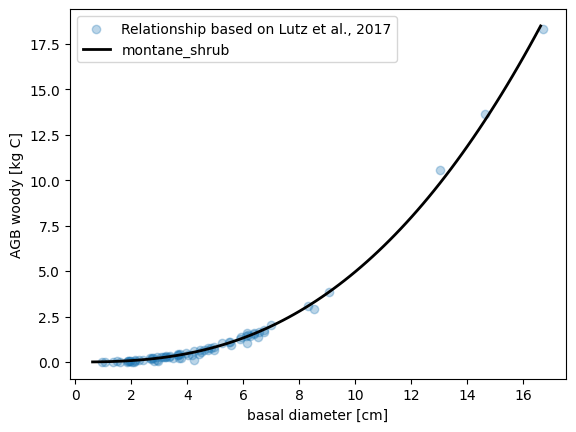

In [170]:
#visualize relationship between basal diameter and abg woody biomass
plt.scatter(conti_raw.BD_Lutz,conti_raw.AGB_woody_kg_C, alpha = 0.3,
            label = "Relationship based on Lutz et al., 2017")
plt.xlabel('basal diameter [cm]')
plt.ylabel('AGB woody [kg C]')


# Fit the fates d2blmax relationship using params that match the Lutz relationship
# shown in the supporting allometric equations section above
conti_BD_AGBW = conti_raw[["BD_Lutz","AGB_woody_kg_C"]]
conti_BD_AGBW = conti_BD_AGBW[conti_BD_AGBW['AGB_woody_kg_C'].notna()]


c2b = g_biomass_per_g_C
#d2bagw_2pwr(d=[3,2], p1=0.3, p2=1.2, c2b=g_biomass_per_g_C)

popt, pcov = curve_fit(lambda d, p1, p2: d2bagw_2pwr(d, p1, p2, c2b),
                       xdata=list(conti_BD_AGBW.BD_Lutz), ydata=list(conti_BD_AGBW.AGB_woody_kg_C))

fates_allom_agb1 = getMeanMinMaxofParam(param = 0)
fates_allom_agb2 = getMeanMinMaxofParam(param = 1)

agb_woody_model = d2bagw_2pwr(basal_diams, fates_allom_agb1[2], fates_allom_agb2[2], c2b = g_biomass_per_g_C)

plt.plot(basal_diams, agb_woody_model, label = "montane_shrub", color = "black", lw = 2)
plt.legend()

print("fates_allom_agb1 =",fates_allom_agb1[0], ";" , "fates_allom_agb2 =" , fates_allom_agb2[0])

add_param_to_allometry_dict("fates_allom_agb1",fates_allom_agb1)
add_param_to_allometry_dict("fates_allom_agb2",fates_allom_agb2)

#### Basal diameter to crown area

d2ca_base [0.17990369 0.26852187 0.22421278]
d2ca_expo: [1.1949319  1.37148614 1.28320902]
fates_allom_blca_expnt_diff [-0.48037912 -0.66622177 -0.57330045]


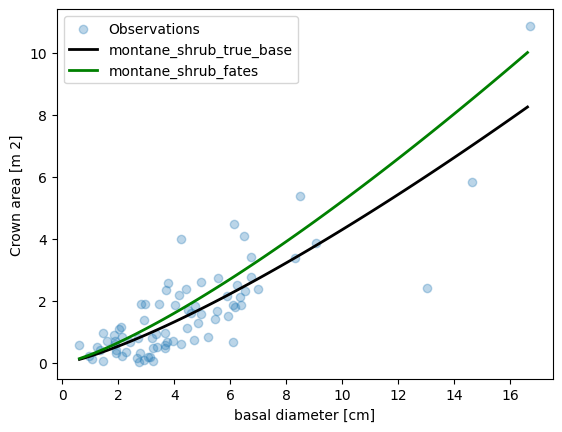

In [171]:
#visualize relationship between basal diameter and crown area
plt.scatter(conti_raw.BD_Lutz,conti_raw.crown_area, alpha = 0.3,
            label = "Observations")
plt.xlabel('basal diameter [cm]')
plt.ylabel('Crown area [m 2]')


conti_BD_CA = conti_raw[["BD_Lutz","crown_area"]]
conti_BD_CA = conti_BD_CA[conti_BD_CA['crown_area'].notna()]


popt, pcov = curve_fit(lambda d, p1, p2: carea_2pwr(d, p1, p2),
                       xdata=list(conti_BD_CA.BD_Lutz), ydata=list(conti_BD_CA.crown_area))


# This parameter is the base of the 2 parameter power function.
# In the FATES code it is called the 'spread term'
# The spread term is actually a dynamic variable based on the
# site-level stand density and two parameters (fates_allom_d2ca_coefficient_max and
# fates_allom_d2ca_coefficient_in) that determine the amount
# of elasticity the crowns should have to respond to the stand density.
# Caution: fates_allom_d2ca_coefficient_(min/max) both affect the ultimate
# crown area

d2ca_base = getMeanMinMaxofParam(param = 0)
d2ca_expo = getMeanMinMaxofParam(param = 1)

# Use variation in the estimate of the base parameter for fates_allom_d2ca_coefficient_(min/max)
fates_allom_d2ca_coefficient_min = [d2ca_base[0] * 0.85, d2ca_base[0] * 1.15, d2ca_base[0]]
fates_allom_d2ca_coefficient_max = [d2ca_base[1] * 0.85, d2ca_base[1] * 1.15, d2ca_base[1]]

print("d2ca_base", d2ca_base)
print("d2ca_expo:",d2ca_expo)

# The exponent in FATES is calculated by adding and "exponent diff param" to fates_allom_d2bl2
fates_allom_blca_expnt_diff = d2ca_expo - fates_allom_d2bl2
add_param_to_allometry_dict("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff)


print("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff)

# Simple crown area model with fitted base and exponent 
crown_area_model = carea_2pwr(basal_diams, d2ca[2], d2ca_expo[2])

# How FATES actually calculates crown area
ca_fates = []
for d in basal_diams:
    #parameterized with Jennifer's value for this
    ca_fates.append(d_to_crown_diameter_fates(d,fates_allom_d2bl2[2],fates_allom_blca_expnt_diff[2],
                                        0.1,d2ca_max=0.523,d2ca_min=0.244))

plt.plot(basal_diams, crown_area_model, label = "montane_shrub_true_base", color = "black", lw = 2)
plt.plot(basal_diams, ca_fates, label = "montane_shrub_fates", color = "green", lw =2)
plt.legend()

In [172]:
print(fates_allom_d2ca_coefficient_min)
print(fates_allom_d2ca_coefficient_max)

[0.1529181387204178, 0.20688924650409463, 0.17990369261225622]
[0.2282435894727728, 0.30880015046316317, 0.268521869967968]


In [173]:
add_param_to_allometry_dict("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff)
add_param_to_allometry_dict("fates_allom_d2ca_coefficient_min",fates_allom_d2ca_coefficient_min)
add_param_to_allometry_dict("fates_allom_d2ca_coefficient_max",fates_allom_d2ca_coefficient_max)

### Size senescence

To get the parameters for this I can calibrate them against the Conti observations such that size-based mortality goes up once we reach the upper limit of size in the database

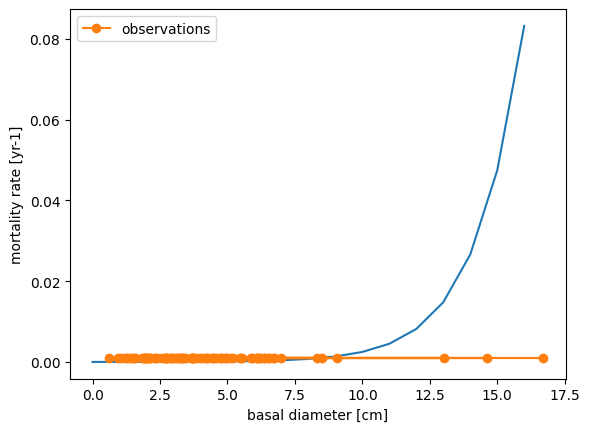

In [174]:
ip_size = 20 #inflection point
r_size = 0.6 #shape parameter

sizes = list(range(round(max(conti_BD_CA.BD_Lutz))))

mort_rates = size_senescence(size = sizes, 
                mort_r_size_senescence = r_size, 
                mort_ip_size_senescence = ip_size)

plt.plot(sizes, mort_rates)
plt.plot(conti_raw.BD_Lutz,[0.001] * len(conti_raw.BD_Lutz), marker = "o", label = "observations")
plt.xlabel("basal diameter [cm]")
plt.ylabel("mortality rate [yr-1]")
plt.legend()
plt.show()

In [175]:
add_param_to_allometry_dict("fates_mort_ip_size_senescence", [ip_size * 0.80, ip_size * 1.20, ip_size])
add_param_to_allometry_dict("fates_mort_r_size_senescence", [r_size * 0.80, r_size * 1.20, r_size])

### Age senescence

This is based on a combo of Ceanothus and Manzanita. Ceanothus sources: Cronemiller; Montygierd and Keeley) Cronemiller says its hard to find a C int specimen older than 45 years.

Manzanita has a normal lifespan of 25 to 50 years [UCANR](https://ucanr.edu/blogs/blogcore/postdetail.cfm?postnum=51198)

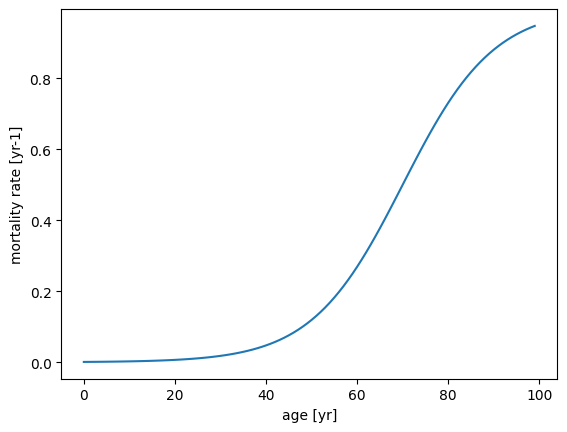

In [176]:
ages = range(100)
r_age = 0.1
ip_age = 70

mort_rates = age_senescence(age = ages, 
                mort_r_age_senescence = r_age, 
                mort_ip_age_senescence = ip_age)

plt.plot(ages, mort_rates)
plt.xlabel("age [yr]")
plt.ylabel("mortality rate [yr-1]")
plt.show()

In [177]:
add_param_to_allometry_dict("fates_mort_ip_age_senescence", [ip_age * 0.80, ip_age * 1.20, ip_age])
add_param_to_allometry_dict("fates_mort_r_age_senescence", [r_age * 0.80, r_age * 1.20, r_age])

## Join all data-derived parameters and export

In [193]:
# Add missing fields to the allometry data
allometry_range_df = pd.DataFrame.from_dict(allometry_dict)
allometry_range_df['median'] = None
allometry_range_df['sample_size'] = len(conti_raw)
allometry_range_df['subset_name'] = "target_shrubs"
allometry_range_df['sources'] = "Conti et al., 2019"


# Join trait and allometry data
param_range_df = pd.concat([trait_range_df,allometry_range_df],axis = 0)
param_range_df["pft"] = "shrub"

# Write CSV
if write_to_csv == True:

    now = datetime.now()
    dt_string = now.strftime("%m-%d-%Y-%H-%M-%S")
    file_path = "shrubs_param_ranges_data_derived_" + dt_string + ".csv"
    param_range_df.to_csv(file_path, index=False)

In [196]:
param_range_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 0 to 14
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fates_name   33 non-null     object 
 1   min_value    33 non-null     float64
 2   max_value    33 non-null     float64
 3   mean         33 non-null     float64
 4   median       18 non-null     float64
 5   sample_size  33 non-null     int64  
 6   subset_name  33 non-null     object 
 7   sources      33 non-null     object 
 8   pft          33 non-null     object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.6+ KB
